# Speech to text
Modern speech to text systems are based on transformer networks.

The model whisper is very simple to install and to use. It can work without any web connectivity.

The only disadvantage of the whisper is the relatively high computational complexity.

## Scientific publication
Publication of the whisper: Robust Speech Recognition via Large-ScaleWeak Supervision

## Installation
The installation can be done in the following three steps:

1) install ffmpeg

2) install git: https://learn.microsoft.com/en-us/devops/develop/git/install-and-set-up-git

3) install whisper: pip install git+https://github.com/openai/whisper.git

or simply by

pip install -U openai-whisper

## Configuration
The whisper can use different languages and model sizes:

<table>
<tr><td>Size</td><td>Parameters</td><td>English-only model</td><td>Multilingual model</td><td>Required VRAM</td><td>Relative speed</td></tr>
<tr><td>tiny</td><td>39 M</td><td>tiny.en</td><td>tiny</td><td>~1 GB</td><td>~32x</td></tr>
<tr><td>base</td><td>74 M</td><td>base.en</td><td>base</td><td>~1 GB</td><td>~16x</td></tr>
<tr><td>small</td><td>244 M</td><td>small.en</td><td>small</td><td>~2 GB</td><td>~6x</td></tr>
<tr><td>medium</td><td>769 M</td><td>medium.en</td><td>medium</td><td>~5 GB</td><td>~2x</td></tr>
<tr><td>large</td><td>1550 M</td><td>N/A</td><td>large</td><td>~10 GB</td><td>1x</td></tr>
</table>
Source: https://github.com/openai/whisper


In [1]:
ModelSize = "small" # ["tiny", "base", "small", "medium", "large"]
Language = 'German' # ["German", "English"]

## Calling the whisper
The whisper can be started by the following code:

In [2]:
import whisper
import torch
import numpy as np
#import pyaudio
#import wave
import time
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
import librosa

import os
os.chdir('../Python')
import TrainingsDataInterface
import WaveInterface

SamplingRateWhisper = 16000 # the sampling rate should always be 16 kHz
devices = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # source: https://github.com/openai/whisper/discussions/373
model = whisper.load_model(ModelSize, device = devices)  

def DoResampling(x, OriginalSamplingRate):
    if np.abs(SamplingRateWhisper - OriginalSamplingRate) > 1:
        y = librosa.resample(x, orig_sr = OriginalSamplingRate, target_sr = SamplingRateWhisper)
        y *= (np.max(np.abs(x)) / np.max(np.abs(y)))
        return y
    else:
        return x

def CallWhisper(x, OriginalSamplingRate):
    y = DoResampling(x, OriginalSamplingRate)
    result = model.transcribe(y.astype(np.float32), language=Language, verbose=0)
    return result["text"]

## Demo
In the following, a small example for the usage of the whisper is shown.

The so called real time factor is computational time or running time divided by the audio length. A real time factor below 1 means, that the algorithm is capable of working in real time.

The latency is the length of the audio recording plus the running time. The latency measurement starts with the beginning of the audio recording and ends with printing out the result.

In [3]:
x, Fs, bits = WaveInterface.ReadWave('../Audio/PferdeSchnaubenNichtDieNase.wav')

start = time.time()
result = CallWhisper(x, Fs)
stop = time.time()
print(result)
RunTime = stop-start
AudioLength = x.shape[0] / Fs
RealTimeFactor = RunTime / AudioLength
print("runtime: " + str(RunTime) + " s")
print("audio length:" + str(AudioLength) + " s")
print("real time factor: " + str(RealTimeFactor))
print("latency: " + str(RunTime + AudioLength) + " s")

C:\Users\spiertz\AppData\Local\Programs\Python\Python311\Lib\site-packages\whisper\transcribe.py:114: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Pferdeschnauben nicht die Nase.
runtime: 6.783752202987671 s
audio length:2.0638095238095238 s
real time factor: 3.287004989910962
latency: 8.847561726797196 s


## Transcription of recording
The following code shows, how to record audio and transcribe it by whisper.

Recording...
Finished recording


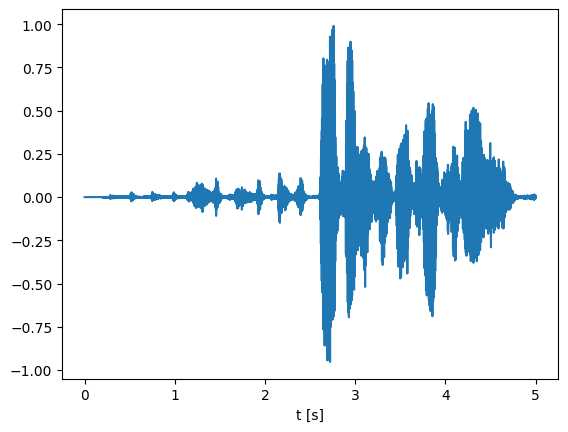

 Heute ist es mir viel zu warm.
runtime: 3.8137319087982178 s
audio length:5.0 s
real time factor: 0.7627463817596436
latency: 8.813731908798218 s


In [4]:
# code-source: https://daehnhardt.com/blog/2023/03/05/python-audio-signal-processing-with-librosa/

# Set the sampling frequency and duration of the recording
duration = 5  # in seconds
filename = 'recording.wav'

# Record audio
print("Recording...")
audio = sd.rec(int(SamplingRateWhisper * duration), samplerate=SamplingRateWhisper, channels=1)
sd.wait()  # Wait until recording is finished
print("Finished recording")

# Save the recorded audio to a WAV file
sf.write(filename, audio, SamplingRateWhisper)

x, Fs, bits = WaveInterface.ReadWave(filename)
x *= 0.99 / np.amax(np.abs(x))
t = np.arange(x.shape[0])/SamplingRateWhisper
plt.plot(t,x)
plt.xlabel('t [s]')
plt.show()

start = time.time()
result = CallWhisper(x, Fs)
stop = time.time()
print(result)
RunTime = stop-start
AudioLength = x.shape[0] / Fs
RealTimeFactor = RunTime / AudioLength
print("runtime: " + str(RunTime) + " s")
print("audio length:" + str(AudioLength) + " s")
print("real time factor: " + str(RealTimeFactor))
print("latency: " + str(RunTime + AudioLength) + " s")

## Error rate, SNR and modelsize

For evaluating the error rate letter by letter, the Levenshtein distance is used (which will be explained in detail in a future Jupyter Notebook). The higher the distance, the more errors are detected.

The following code tests the following statements:

1) The lower the SNR, the higher the error rate evaluated by the Levenshtein distance.

2) The bigger the model, the lower the error rate evaluated by the Levenshtein distance.

3) Is the evaluation time depending on the model size?

KeyboardInterrupt: 

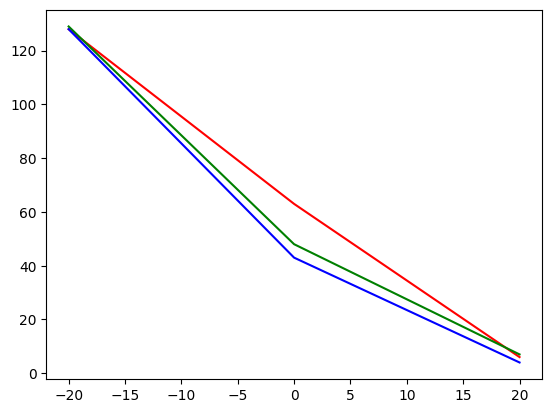

In [5]:
from Levenshtein import distance as lev

ListOfSentences = []
ListOfSentences.append('Heute ist es mir viel zu warm.')
ListOfSentences.append('Pferde schnauben nicht die Nase.')
ListOfSentences.append('Früher war mehr Lametta.')
ListOfSentences.append('Liebeskummer lohnt sich nicht, mein Darling.')

def AddNoise(x, TargetdB):
    n = np.random.randn(x.shape[0])
    a = np.sqrt(np.sum(x**2) / (np.sum(n**2) * 10**(TargetdB/10)))
    y = x + a*n
    assert np.abs(TargetdB - 10*np.log10(np.sum(x**2) / np.sum((x-y)**2))) < 1e-2, 'error in evaluating TargetdB'
    return y

def GetWave(n):
    assert n >= 0, 'n too small'
    assert n < len(ListOfSentences), 'n too big'
    Filename = 'tmp_' + str(n) + '.wav'
    try:
        x, Fs, bits = WaveInterface.ReadWave(Filename)
    except:
        import pyttsx3
        engine = pyttsx3.init()
        engine.setProperty('voice', 'german')
        engine.save_to_file(ListOfSentences[n], Filename)
        engine.runAndWait()
        x, Fs, bits = WaveInterface.ReadWave(Filename)
    return x, Fs

class CModelSetup(object):

    def __init__(self, ModelSize, Colour):
        self.__ModelSize = ModelSize
        self.__Colour = Colour

    def GetModelSize(self):
        return self.__ModelSize

    def GetColour(self):
        return self.__Colour

ListOfModels = []
ListOfModels.append(CModelSetup("tiny", 'r'))
ListOfModels.append(CModelSetup("base", 'g'))
ListOfModels.append(CModelSetup("small", 'b'))
ListOfModels.append(CModelSetup("medium", 'k'))

SNRList = [-20, 0, 20]
TimeConsumption = np.zeros((len(ListOfModels)))

def EvalSingleModel(ModelIndex):
    model = whisper.load_model(ListOfModels[ModelIndex].GetModelSize(), device = devices) 
    d = np.zeros((len(SNRList)))
    for i in range(len(ListOfSentences)):
        x, Fs = GetWave(i)
        for n in range(len(SNRList)):
            y = AddNoise(x, SNRList[n])
            StartTime = time.time()
            TextDetected = CallWhisper(y, Fs)
            StopTime = time.time()
            TimeConsumption[ModelIndex] += StopTime - StartTime
            d[n] += lev(ListOfSentences[i], TextDetected.strip())
    return d

for ModelIndex in range(len(ListOfModels)):
    plt.plot(SNRList, EvalSingleModel(ModelIndex), ListOfModels[ModelIndex].GetColour(), label = ListOfModels[ModelIndex].GetModelSize())
plt.xlabel('SNR [dB]')
plt.ylabel('Levenshtein distance')
plt.legend(loc = "upper right")
plt.show()

plt.plot(TimeConsumption)
plt.xlabel('modelsize')
plt.ylabel('t [s]')
plt.title('time consumption')
plt.show()

## Programming exercise
Evaluate the accuracy for the whisper and the german set of trainings data used in this course.

Due to misleading transcriptions, the TranscriptionDictionary must be used. E.g. null and 0 results in the same waveform. In order to evaluate a correct confusion matrix, the TranscriptionDictionary must be filled step by step, by interpreting the output of the code line print('correct: ', command_groundtruth, ', estimated: ', command_estimated).

Due to misleading transcriptions, an additional set of rules is necessary, e.g. removing leading and trailing blanks, or removing points or other signs from the detected command, which are usally not spoken, e.g. '.' or '!'. Extend the given set of rules in the procedure ApplySetOfRules, if you notice a confusing output of the code line code line print('correct: ', command_groundtruth, ', estimated: ', command_estimated).

In [ ]:
FastEvaluation = True

TranscriptionDictionary = {}
TranscriptionDictionary['null'] = '0'
TranscriptionDictionary['eins'] = '1'
 # solution begins

# solution ends

def ApplySetOfRules(InputString):
    InputString = InputString.lower() # transform to lower cases
    InputString = InputString.replace(" ","") # remove blanks
    # solution begins

    # solution ends
    return InputString

NumberOfTests = 0
NumberOfHits = 0
ATrainingsDataInterface = TrainingsDataInterface.CTrainingsDataInterface()
for CommandIndex in range(ATrainingsDataInterface.GetNumberOfCommands()):
    command_groundtruth = ATrainingsDataInterface.GetCommandString(CommandIndex).lower()
    if FastEvaluation:
        MaxInstanceIndex = 5
    else:
        MaxInstanceIndex = ATrainingsDataInterface.GetNumberOfCommandInstances(CommandIndex)
    for InstanceIndex in range(MaxInstanceIndex):
        x, Fs, bits = ATrainingsDataInterface.GetWaveOfCommandInstance(CommandIndex, InstanceIndex)
        command_estimated = CallWhisper(x, Fs)
        command_estimated = ApplySetOfRules(command_estimated)
        
        NumberOfTests += 1
        if command_estimated in TranscriptionDictionary.keys():
            command_estimated = TranscriptionDictionary.get(command_estimated)
        if command_estimated == command_groundtruth:
            NumberOfHits += 1
        else:
            print('wrong detection: correct: ', command_groundtruth, ', estimated: ', command_estimated)

accuracy = NumberOfHits / NumberOfTests
print('accuracy = ', NumberOfHits / NumberOfTests)
assert accuracy > 0.6, 'not enough elements in TranscriptionDictionary or not enough rules in procedure ApplySetOfRules'

## Exam preparation

1) A transcription of $30$ seconds of audio takes $28$ seconds to transcribe to a text. Evaluate the latency and the real time factor. Is the algorithm capable of working in real time?

2) For real time appclications in speech to text, a latency of $500$ ms is reasonable. According to your experiments in this jupyter notebook: is the whisper usable in such a real time application?